# Resultados

En esta notebook analizamos resultados pero centrando en aquellos marcados como "regionales".

In [13]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_regionalism = pd.read_csv("../data/regionalisms/check_regionalisms_annotated.csv", index_col=0)

df_regionalism = df_regionalism.rename(columns={"CHECK": "is_regional"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nos quedamos con los índices de los tweets que tengan slang.



In [14]:
indices = df_regionalism[df_regionalism["is_regional"] > 0].index

len(indices)

1547

In [15]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/test*pred*12shot.csv")),
    "beto": sorted(glob("../data/test*beto.csv")),
    "aya": sorted(glob("../data/test*aya_.csv")),
    "mixtral": sorted(glob("../data/test*mixtral.csv")),
}

assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}

# Me quedo sólo con los que tienen regionalismos

dfs_regional = {k: v[v.index.isin(indices)] for k, v in dfs.items()}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]

model_order = ["aya", "gpt-3.5", "mixtral", "beto"]
pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

In [17]:
dfs["beto"][all_labels].mean()

WOMEN         0.023104
LGBTI         0.015520
RACISM        0.040564
CLASS         0.013404
POLITICS      0.025397
DISABLED      0.011640
APPEARANCE    0.033333
CRIMINAL      0.032628
dtype: float64

In [7]:
dfs_regional["beto"][all_labels].mean()

WOMEN         0.052359
LGBTI         0.021978
RACISM        0.049127
CLASS         0.034906
POLITICS      0.066580
DISABLED      0.022624
APPEARANCE    0.059470
CRIMINAL      0.032321
dtype: float64

Chequear que tengan todas la misma long

In [25]:
{key: len(value) for key, value in dfs.items()}

{'gpt-3.5': 1547, 'beto': 1547, 'aya': 1547, 'mixtral': 1547}

In [94]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [36]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score, num_bootstraps=150)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


gpt-3.5


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

aya


  0%|          | 0/4 [00:00<?, ?it/s]

mixtral


  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,gpt-3.5,WOMEN,f1,0.3768
1,gpt-3.5,WOMEN,f1,0.4568
2,gpt-3.5,WOMEN,f1,0.3671
3,gpt-3.5,WOMEN,f1,0.4342
4,gpt-3.5,WOMEN,f1,0.4258
...,...,...,...,...
7195,mixtral,CLASS,precision,0.2906
7196,mixtral,CLASS,precision,0.2791
7197,mixtral,CLASS,precision,0.2764
7198,mixtral,CLASS,precision,0.2130


In [38]:
pd.options.display.float_format = "{:.4f}".format

pd.options.display.max_rows = 100


f1s = df_metrics[df_metrics["metric"] == "f1"]


f1s.groupby(["model", "label", "metric"]).agg(["mean", "std"])

score       
                        mean    std
model   label  metric              
aya     CLASS  f1     0.2003 0.0310
        LGBTI  f1     0.2533 0.0528
        RACISM f1     0.4593 0.0408
        WOMEN  f1     0.2579 0.0338
beto    CLASS  f1     0.6732 0.0619
        LGBTI  f1     0.4722 0.0801
        RACISM f1     0.7012 0.0479
        WOMEN  f1     0.5108 0.0552
gpt-3.5 CLASS  f1     0.4739 0.0583
        LGBTI  f1     0.4887 0.0755
        RACISM f1     0.6400 0.0428
        WOMEN  f1     0.4086 0.0532
mixtral CLASS  f1     0.3602 0.0460
        LGBTI  f1     0.4930 0.0619
        RACISM f1     0.6091 0.0400
        WOMEN  f1     0.3682 0.0460

In [11]:
full_results = pd.read_csv("../results/full_results.csv", index_col=0)


diff = df_metrics.groupby(["model", "label", "metric"]).agg("mean") - full_results.groupby(["model", "label", "metric"]).agg("mean")

diff = diff.reset_index()

NameError: name 'df_metrics' is not defined

NameError: name 'diff' is not defined

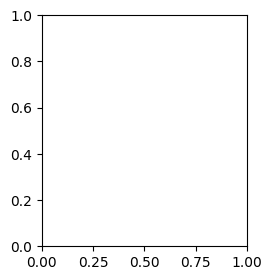

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(df, metric, labels, legend=True):


    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "f1"
plt.figure(figsize=(9, 3))


plt.subplot(1, 3, 1)
plot_metric(diff, metric, all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

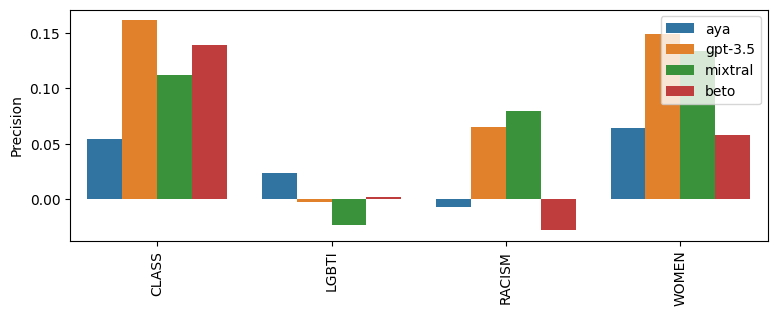

In [64]:
plot_metric(diff, "precision", all_labels)

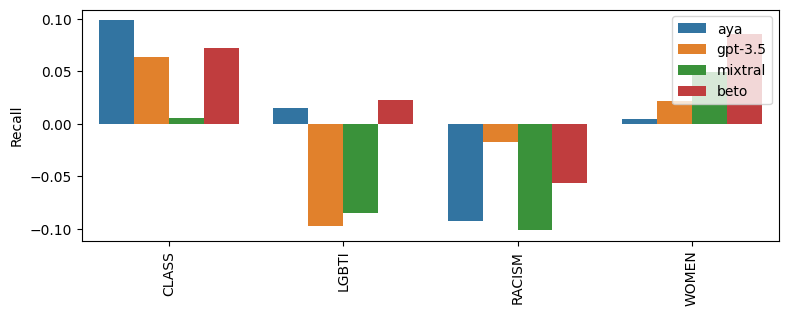

In [66]:
plot_metric(diff, "recall", all_labels)

¿Qué pasa que mejora tanto todo en CLASE?

In [8]:
df_beto = dfs["beto"]

df_beto["HATEFUL"].mean()

0.1544973544973545

In [9]:
df_beto[all_labels].sum()

WOMEN         131
LGBTI          88
RACISM        230
CLASS          76
POLITICS      144
DISABLED       66
APPEARANCE    189
CRIMINAL      185
dtype: int64

Ok! Hay muchos más odio en este conjunto de datos (cerca de 1 sobre 4) vs 1 sobre 7 en el conjunto en general

Ok, acá vemos lo siguiente:

- En CLASE, los 

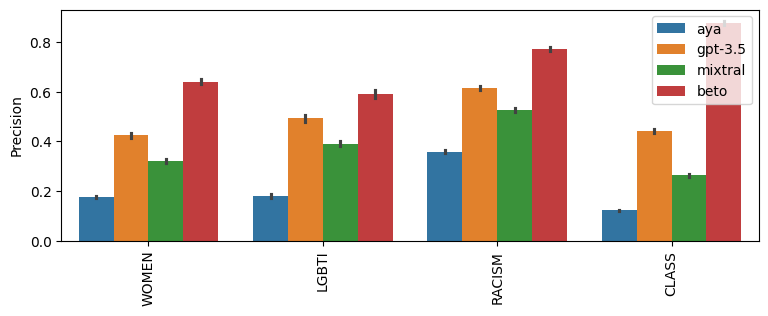

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df_metrics[(df_metrics["metric"] == metric) & (df_metrics["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(metric, all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

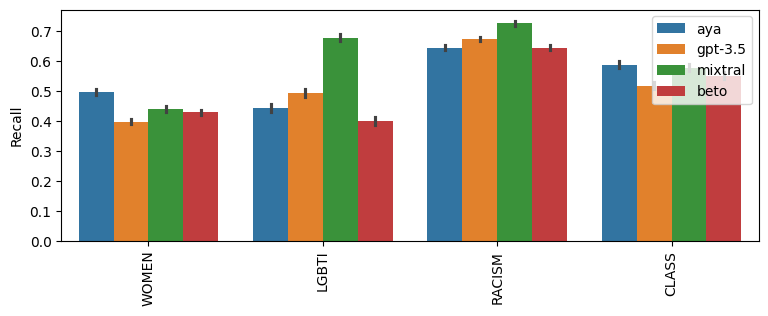

In [40]:
plot_metric("recall", all_labels)
#plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

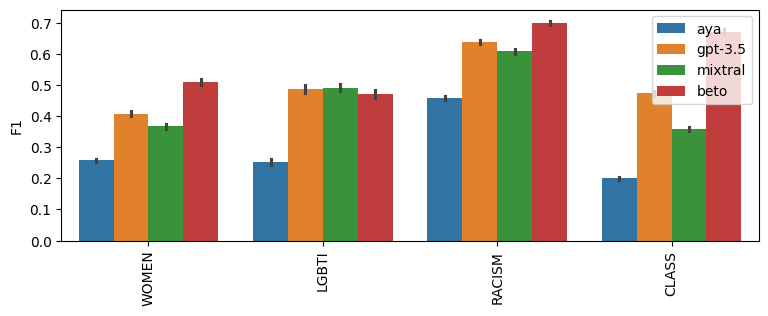

In [42]:
plot_metric("f1", all_labels)
#plt.savefig(f"img/f1.png", bbox_inches='tight', dpi=300)

In [45]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,f1,0.5618
1,gpt-3.5,f1,0.5519
2,gpt-3.5,f1,0.5451
3,gpt-3.5,f1,0.5702
4,gpt-3.5,f1,0.5621
...,...,...,...
1795,mixtral,precision,0.3636
1796,mixtral,precision,0.3753
1797,mixtral,precision,0.3702
1798,mixtral,precision,0.3315


([0, 1, 2], [Text(0, 0, 'f1'), Text(1, 0, 'recall'), Text(2, 0, 'precision')])

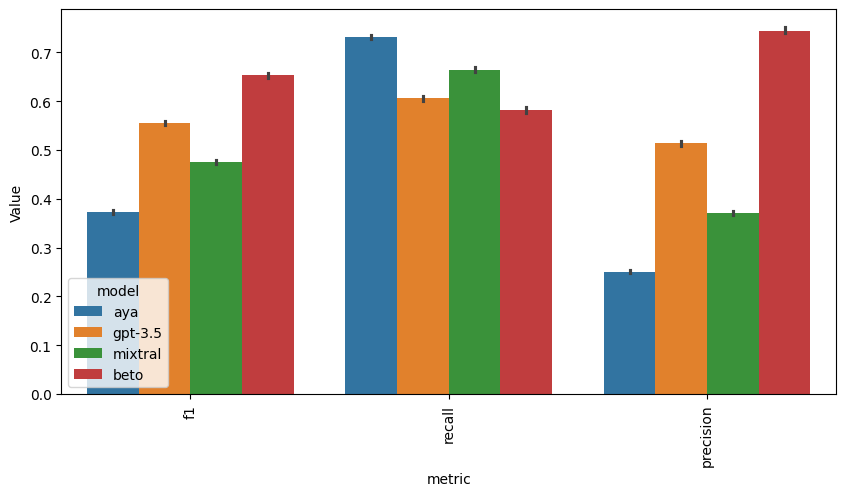

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()